In [18]:
import yaml
# ╔══════════════════════════════════════════════════════════════════════════════╗
# ║                                                                             ║
# ║   YOLO ANNOTATION REVIEWER — Complete Standalone Notebook (+ MOUSE DRAW)   ║
# ║                                                                             ║
# ║   Dependencies: pip install ultralytics opencv-python-headless matplotlib  ║
# ║   Works in: JupyterLab, Jupyter Notebook, VS Code, Google Colab            ║
# ║                                                                             ║
# ╚══════════════════════════════════════════════════════════════════════════════╝
#
#  CELL 1 — Paste everything below into a SINGLE cell and run it.
#  Then use Cell 2/3/4 as shown at the bottom.
# =============================================================================

from __future__ import annotations

import json
import os
import random
import shutil
import uuid
from dataclasses import dataclass, field, asdict
from datetime import datetime, timezone
from enum import Enum
from pathlib import Path
from typing import Any, Dict, List, Optional, Tuple, Counter

import cv2
import numpy as np

try:
    from IPython.display import display, clear_output, Image as IPyImage, HTML
except ImportError:
    raise ImportError("Run this inside Jupyter.")

try:
    from ultralytics import YOLO
except ImportError:
    raise ImportError("ultralytics is required: pip install ultralytics")

try:
    import matplotlib
    matplotlib.use('module://matplotlib_inline.backend_inline')
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    from matplotlib.widgets import Button, RadioButtons
except ImportError:
    raise ImportError("matplotlib is required: pip install matplotlib")


# ═══════════════════════════════════════════════════════════════════════════════
#  §1  DATA MODELS
# ═══════════════════════════════════════════════════════════════════════════════

class Status(Enum):
    PENDING   = "pending"
    APPROVED  = "approved"
    CORRECTED = "corrected"
    REJECTED  = "rejected"


@dataclass
class BBox:
    """Bounding box in pixel coords (x1, y1, x2, y2)."""
    x1: float
    y1: float
    x2: float
    y2: float
    class_id: int = 0
    class_name: str = ""
    confidence: float = 1.0
    manual: bool = False
    uid: str = field(default_factory=lambda: uuid.uuid4().hex[:8])

    @property
    def cx(self) -> float: return (self.x1 + self.x2) / 2
    @property
    def cy(self) -> float: return (self.y1 + self.y2) / 2
    @property
    def w(self) -> float:  return abs(self.x2 - self.x1)
    @property
    def h(self) -> float:  return abs(self.y2 - self.y1)

    def is_valid(self, min_px: float = 2.0) -> bool:
        return self.w >= min_px and self.h >= min_px

    def clamp(self, iw: int, ih: int) -> "BBox":
        return BBox(
            x1=max(0, min(self.x1, iw)), y1=max(0, min(self.y1, ih)),
            x2=max(0, min(self.x2, iw)), y2=max(0, min(self.y2, ih)),
            class_id=self.class_id, class_name=self.class_name,
            confidence=self.confidence, manual=self.manual, uid=self.uid,
        )

    def to_yolo(self, iw: int, ih: int) -> str:
        return (
            f"{self.class_id} "
            f"{self.cx / iw:.6f} {self.cy / ih:.6f} "
            f"{self.w / iw:.6f} {self.h / ih:.6f}"
        )


@dataclass
class Frame:
    """One extracted video frame and its annotations."""
    index: int
    image_path: str
    img_w: int = 0
    img_h: int = 0
    bboxes: List[BBox] = field(default_factory=list)
    status: Status = Status.PENDING
    notes: str = ""

    def yolo_lines(self) -> List[str]:
        return [b.to_yolo(self.img_w, self.img_h) for b in self.bboxes]


class ClassMap:
    """Bidirectional class_id ↔ class_name registry."""
    def __init__(self, names: Optional[Dict[int, str]] = None):
        self._i2n: Dict[int, str] = dict(names) if names else {}
        self._n2i: Dict[str, int] = {v: k for k, v in self._i2n.items()}

    def add(self, cid: int, name: str):
        self._i2n[cid] = name; self._n2i[name] = cid

    def name(self, cid: int) -> str:
        return self._i2n.get(cid, f"class_{cid}")

    def id(self, name: str) -> int:
        if name not in self._n2i:
            nid = max(self._i2n.keys(), default=-1) + 1
            self.add(nid, name)
        return self._n2i[name]

    @property
    def names(self) -> List[str]:
        return [self._i2n[k] for k in sorted(self._i2n)]

    def as_dict(self) -> Dict[int, str]:
        return dict(sorted(self._i2n.items()))

    def __len__(self) -> int:
        return len(self._i2n)

    def __contains__(self, key) -> bool:
        return key in self._i2n if isinstance(key, int) else key in self._n2i


# ═══════════════════════════════════════════════════════════════════════════════
#  §2  FRAME EXTRACTION + YOLO INFERENCE
# ═══════════════════════════════════════════════════════════════════════════════

def extract_and_detect(
    video_path: str,
    model: YOLO,
    output_dir: Path,
    stride: int = 1,
    max_frames: Optional[int] = None,
    conf: float = 0.25,
    iou: float = 0.45,
    device: str = "",
) -> Tuple[List[Frame], ClassMap]:
    """
    Extract frames from video, run YOLO inference on each, return
    (list of Frame, ClassMap built from model.names).
    """
    output_dir.mkdir(parents=True, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError(f"Cannot open video: {video_path}")

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    print(f"📹 Video: {Path(video_path).name}  |  {total_frames} frames  |  {fps:.1f} FPS")
    print(f"   Stride: {stride}  |  conf≥{conf}  |  iou≥{iou}")

    # Build class map from model
    cmap = ClassMap(model.names)

    frames: List[Frame] = []
    idx = saved = 0
    try:
        while True:
            ret, img = cap.read()
            if not ret:
                break
            if idx % stride == 0:
                # Save frame
                fname = f"frame_{idx:06d}.jpg"
                fpath = output_dir / fname
                cv2.imwrite(str(fpath), img, [cv2.IMWRITE_JPEG_QUALITY, 95])
                h, w = img.shape[:2]

                # Run YOLO
                results = model.predict(
                    source=img, conf=conf, iou=iou,
                    device=device, verbose=False,
                )
                bboxes = []
                if results and results[0].boxes is not None:
                    boxes = results[0].boxes
                    for xyxy, cls_t, conf_t in zip(
                        boxes.xyxy.cpu().numpy(),
                        boxes.cls.cpu().numpy(),
                        boxes.conf.cpu().numpy(),
                    ):
                        cid = int(cls_t)
                        bboxes.append(BBox(
                            x1=float(xyxy[0]), y1=float(xyxy[1]),
                            x2=float(xyxy[2]), y2=float(xyxy[3]),
                            class_id=cid,
                            class_name=cmap.name(cid),
                            confidence=float(conf_t),
                        ))

                frames.append(Frame(
                    index=idx, image_path=str(fpath),
                    img_w=w, img_h=h, bboxes=bboxes,
                ))
                saved += 1
                if saved % 50 == 0:
                    print(f"   … extracted & detected {saved} frames")
                if max_frames and saved >= max_frames:
                    break
            idx += 1
    finally:
        cap.release()

    print(f"✅ {saved} frames extracted → {output_dir}")
    total_det = sum(len(f.bboxes) for f in frames)
    print(f"   {total_det} total detections across all frames")
    return frames, cmap


# ═════════════════���═════════════════════════════════════════════════════════════
#  §3  PERSISTENCE  (JSON checkpoint)
# ═══════════════════════════════════════════════════════════════════════════════

def save_checkpoint(path: Path, frames: List[Frame], cmap: ClassMap) -> None:
    """Atomic JSON save."""
    data = {
        "saved_at": datetime.now(timezone.utc).isoformat(),
        "class_map": {str(k): v for k, v in cmap.as_dict().items()},
        "frames": [],
    }
    for f in frames:
        data["frames"].append({
            "index": f.index, "image_path": f.image_path,
            "img_w": f.img_w, "img_h": f.img_h,
            "status": f.status.value, "notes": f.notes,
            "bboxes": [asdict(b) for b in f.bboxes],
        })
    tmp = path.with_suffix(".tmp")
    tmp.write_text(json.dumps(data, indent=2, ensure_ascii=False), encoding="utf-8")
    tmp.replace(path)
    print(f"💾 Checkpoint saved ({len(frames)} frames)")


def load_checkpoint(path: Path) -> Tuple[List[Frame], ClassMap]:
    """Load from JSON."""
    data = json.loads(path.read_text(encoding="utf-8"))
    cmap = ClassMap({int(k): v for k, v in data["class_map"].items()})
    frames = []
    for e in data["frames"]:
        bboxes = [BBox(**b) for b in e.get("bboxes", [])]
        try:
            status = Status(e["status"])
        except ValueError:
            status = Status.PENDING
        frames.append(Frame(
            index=e["index"], image_path=e["image_path"],
            img_w=e.get("img_w", 0), img_h=e.get("img_h", 0),
            bboxes=bboxes, status=status, notes=e.get("notes", ""),
        ))
    print(f"📂 Loaded checkpoint ({len(frames)} frames)")
    return frames, cmap


# ═══════════════════════════════════════════════════════════════════════════════
#  §4  RENDERER
# ═══════════════════════════════════════════════════════════════════════════════

PALETTE = [
    (230,25,75),(60,180,75),(255,225,25),(0,130,200),(245,130,48),
    (145,30,180),(70,240,240),(240,50,230),(210,245,60),(250,190,212),
    (0,128,128),(220,190,255),(170,110,40),(255,250,200),(128,0,0),
    (170,255,195),(128,128,0),(255,215,180),(0,0,128),(128,128,128),
]


def render(
    img: np.ndarray,
    bboxes: List[BBox],
    cmap: ClassMap,
    selected_uid: Optional[str] = None,
    thickness: int = 2,
    font_scale: float = 0.50,
) -> np.ndarray:
    """Draw boxes + labels on a copy of the image."""
    vis = img.copy()
    for b in bboxes:
        color = PALETTE[b.class_id % len(PALETTE)]
        t = thickness + 3 if b.uid == selected_uid else thickness
        p1, p2 = (int(b.x1), int(b.y1)), (int(b.x2), int(b.y2))
        cv2.rectangle(vis, p1, p2, color, t)

        tag = " ✋" if b.manual else ""
        label = f"[{b.uid}] {cmap.name(b.class_id)} {b.confidence:.2f}{tag}"
        (tw, th), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, 1)
        cv2.rectangle(vis, (p1[0], max(0, p1[1]-th-8)), (p1[0]+tw+6, p1[1]), color, -1)
        cv2.putText(vis, label, (p1[0]+3, max(th+4, p1[1]-4)),
                    cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255,255,255), 1, cv2.LINE_AA)
    return vis


def show_image(img: np.ndarray, max_width: int = 960) -> None:
    """Display a BGR numpy image inline in Jupyter."""
    h, w = img.shape[:2]
    if w > max_width:
        s = max_width / w
        img = cv2.resize(img, (int(w*s), int(h*s)), interpolation=cv2.INTER_AREA)
    _, buf = cv2.imencode(".png", img)
    display(IPyImage(data=buf.tobytes()))


# ═══════════════════════════════════════════════════════════════════════════════
#  §4B  INTERACTIVE BBOX DRAWER (NEW!)
# ═══════════════════════════════════════════════════════════════════════════════

class InteractiveBBoxDrawer:
    """Interactive bounding box drawer using matplotlib - FULLY DEBUGGED."""

    def __init__(self, image: np.ndarray, class_options: List[str], existing_bboxes: List[BBox] = None):
        """
        Args:
            image: BGR image (opencv format)
            class_options: List of class names
            existing_bboxes: Optional list of existing boxes to show
        """
        print(f"\n🔍 DEBUG: Initializing drawer...")
        print(f"   Image type: {type(image)}")
        print(f"   Image shape: {image.shape if image is not None else 'None'}")
        print(f"   Image dtype: {image.dtype if image is not None else 'None'}")

        # Check if image is valid
        if image is None or image.size == 0:
            raise ValueError("❌ Image is None or empty!")

        # FIX: Proper color conversion with validation
        if len(image.shape) == 3 and image.shape[2] == 3:
            # OpenCV loads as BGR, convert to RGB
            self.image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            print(f"   ✅ Converted BGR→RGB")
        elif len(image.shape) == 2:
            # Grayscale - convert to RGB
            self.image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
            print(f"   ✅ Converted GRAY→RGB")
        else:
            self.image = image.copy()
            print(f"   ⚠️  Using image as-is")

        print(f"   Final image shape: {self.image.shape}")
        print(f"   Value range: [{self.image.min()}, {self.image.max()}]")

        self.img_height, self.img_width = self.image.shape[:2]
        print(f"   Dimensions: {self.img_width}x{self.img_height}")

        self.class_options = class_options if class_options else ["default"]
        self.existing_bboxes = existing_bboxes or []
        self.new_bboxes: List[Dict] = []
        self.current_rect = None
        self.start_point = None
        self.selected_class = self.class_options[0]
        self.finished = False
        self.drawing = False

        print(f"   Classes: {len(self.class_options)}")
        print(f"   Existing boxes: {len(self.existing_bboxes)}")

        # Setup figure
        print(f"\n📊 Creating matplotlib figure...")

        try:
            self.fig, self.ax = plt.subplots(1, 1, figsize=(12, 8))
            print(f"   ✅ Figure created")

            plt.subplots_adjust(left=0.2, right=0.98, top=0.95, bottom=0.05)
            print(f"   ✅ Layout adjusted")

        except Exception as e:
            print(f"   ❌ Error creating figure: {e}")
            import traceback
            traceback.print_exc()
            raise

        # Draw image FIRST (with error handling)
        print(f"\n🎨 About to draw image...")
        try:
            self.redraw_image()
            print(f"   ✅ Image drawn successfully")
        except Exception as e:
            print(f"   ❌ Error in redraw_image: {e}")
            import traceback
            traceback.print_exc()
            raise

        # Force render
        try:
            self.fig.canvas.draw()
            print(f"   ✅ Canvas drawn")
        except Exception as e:
            print(f"   ⚠️  Canvas draw warning: {e}")

        # Connect mouse events
        print(f"\n🖱️  Connecting mouse events...")
        try:
            self.cid_press = self.fig.canvas.mpl_connect('button_press_event', self.on_press)
            self.cid_motion = self.fig.canvas.mpl_connect('motion_notify_event', self.on_motion)
            self.cid_release = self.fig.canvas.mpl_connect('button_release_event', self.on_release)
            print(f"   ✅ Events connected: press={self.cid_press}, motion={self.cid_motion}, release={self.cid_release}")
        except Exception as e:
            print(f"   ❌ Error connecting events: {e}")
            import traceback
            traceback.print_exc()

        # Add controls
        print(f"\n🎛️  Adding controls...")
        try:
            self.add_controls()
            print(f"   ✅ Controls added")
        except Exception as e:
            print(f"   ❌ Error adding controls: {e}")
            import traceback
            traceback.print_exc()

        # Final canvas update
        try:
            self.fig.canvas.draw()
            self.fig.canvas.flush_events()
            print(f"   ✅ Final canvas update")
        except:
            pass

        print(f"\n✅ Drawer initialization complete!\n")

    def redraw_image(self):
        """Redraw the image with all boxes."""
        print(f"   Redrawing image...")

        try:
            self.ax.clear()

            # Display image
            im = self.ax.imshow(
                self.image,
                aspect='auto',
                interpolation='bilinear',
                origin='upper',
                extent=[0, self.img_width, self.img_height, 0]
            )

            # Title without emojis
            self.ax.set_title(
                f"Click and drag to draw | Class: {self.selected_class}\n"
                f"Existing: {len(self.existing_bboxes)} | New: {len(self.new_bboxes)}",
                fontsize=11, pad=10
            )

            # Set axis limits
            self.ax.set_xlim(0, self.img_width)
            self.ax.set_ylim(self.img_height, 0)

            # Draw existing boxes (gray)
            for b in self.existing_bboxes:
                rect = patches.Rectangle(
                    (b.x1, b.y1), b.x2 - b.x1, b.y2 - b.y1,
                    linewidth=1.5, edgecolor='gray', facecolor='none', linestyle='--', alpha=0.6
                )
                self.ax.add_patch(rect)
                self.ax.text(b.x1, max(0, b.y1 - 5), f"{b.class_name}",
                            color='gray', fontsize=8, weight='bold',
                            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7))

            # Draw new boxes (green)
            for i, anno in enumerate(self.new_bboxes):
                x1, y1, x2, y2 = anno['bbox']
                rect = patches.Rectangle(
                    (x1, y1), x2 - x1, y2 - y1,
                    linewidth=2.5, edgecolor='lime', facecolor='none', alpha=0.9
                )
                self.ax.add_patch(rect)
                label_text = f"{anno['class']} ({i+1})"
                self.ax.text(x1, max(0, y1 - 5), label_text,
                            color='white', fontsize=9, weight='bold',
                            bbox=dict(boxstyle='round,pad=0.3', facecolor='green', alpha=0.9))

            print(f"   Drew {len(self.existing_bboxes)} existing + {len(self.new_bboxes)} new boxes")

        except Exception as e:
            print(f"   ERROR in redraw_image: {e}")
            import traceback
            traceback.print_exc()
            raise

    def add_controls(self):
        """Add UI controls."""
        left_margin = 0.02
        control_width = 0.15

        # Radio buttons
        ax_radio = plt.axes([left_margin, 0.40, control_width, 0.45])
        ax_radio.set_title("Select Class:", fontsize=9, loc='left', pad=5)

        visible_classes = self.class_options[:15] if len(self.class_options) > 15 else self.class_options
        self.radio = RadioButtons(ax_radio, visible_classes, active=0)
        self.radio.on_clicked(self.on_class_select)

        # Done button
        ax_done = plt.axes([left_margin, 0.30, control_width, 0.06])
        self.btn_done = Button(ax_done, 'Done', color='#90EE90', hovercolor='#00FF00')
        self.btn_done.label.set_fontsize(10)
        self.btn_done.on_clicked(self.on_done)

        # Delete last button
        ax_delete = plt.axes([left_margin, 0.23, control_width, 0.06])
        self.btn_delete = Button(ax_delete, 'Delete Last', color='#FFB6C1', hovercolor='#FF0000')
        self.btn_delete.label.set_fontsize(9)
        self.btn_delete.on_clicked(self.on_delete_last)

        # Clear all button
        ax_clear = plt.axes([left_margin, 0.16, control_width, 0.06])
        self.btn_clear = Button(ax_clear, 'Clear All', color='#FFFFE0', hovercolor='#FFA500')
        self.btn_clear.label.set_fontsize(9)
        self.btn_clear.on_clicked(self.on_clear_all)

        # Info panel
        ax_info = plt.axes([left_margin, 0.05, control_width, 0.10])
        ax_info.axis('off')
        info_text = (
            f"Stats:\n"
            f"  New: {len(self.new_bboxes)}\n"
            f"  Existing: {len(self.existing_bboxes)}\n\n"
            f"Click & drag on image"
        )
        ax_info.text(0, 0.5, info_text, fontsize=8, va='center',
                    bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.7))

    def on_class_select(self, label):
        """Update selected class."""
        self.selected_class = label
        print(f"📝 Selected class: {label}")
        self.redraw_image()
        try:
            self.fig.canvas.draw()
        except:
            pass

    def on_press(self, event):
        """Mouse press - start drawing."""
        print(f"🖱️  PRESS: button={event.button}, inaxes={event.inaxes == self.ax}")

        if event.inaxes != self.ax:
            print("   ⚠️  Click outside image")
            return

        if event.xdata is None or event.ydata is None:
            print("   ⚠️  Invalid coordinates")
            return

        self.drawing = True
        self.start_point = (int(event.xdata), int(event.ydata))
        print(f"   ✅ Start: {self.start_point}")

        # Create temporary rectangle
        self.current_rect = patches.Rectangle(
            self.start_point, 0, 0,
            linewidth=2, edgecolor='yellow', facecolor='none', linestyle='--', alpha=0.8
        )
        self.ax.add_patch(self.current_rect)
        try:
            self.fig.canvas.draw()
        except:
            pass

    def on_motion(self, event):
        """Mouse motion - update bbox."""
        if not self.drawing or self.start_point is None:
            return

        if event.inaxes != self.ax or event.xdata is None or event.ydata is None:
            return

        x0, y0 = self.start_point
        x1, y1 = int(event.xdata), int(event.ydata)

        self.current_rect.set_width(x1 - x0)
        self.current_rect.set_height(y1 - y0)

        try:
            self.fig.canvas.draw()
        except:
            pass

    def on_release(self, event):
        """Mouse release - finalize bbox."""
        print(f"🖱️  RELEASE")

        if not self.drawing or self.start_point is None:
            print("   ⚠️  Not drawing")
            return

        self.drawing = False

        if event.inaxes != self.ax or event.xdata is None or event.ydata is None:
            print("   ⚠️  Released outside")
            if self.current_rect:
                self.current_rect.remove()
            self.start_point = None
            self.current_rect = None
            return

        x0, y0 = self.start_point
        x1, y1 = int(event.xdata), int(event.ydata)

        # Normalize
        x_min = max(0, min(x0, x1))
        x_max = min(self.img_width, max(x0, x1))
        y_min = max(0, min(y0, y1))
        y_max = min(self.img_height, max(y0, y1))

        width = x_max - x_min
        height = y_max - y_min

        print(f"   📏 Box: {width}x{height}")

        # Validate
        if width < 10 or height < 10:
            print(f"   ⚠️  Too small")
            if self.current_rect:
                self.current_rect.remove()
            self.start_point = None
            self.current_rect = None
            try:
                self.fig.canvas.draw()
            except:
                pass
            return

        # Store
        bbox = [x_min, y_min, x_max, y_max]
        self.new_bboxes.append({
            'bbox': bbox,
            'class': self.selected_class
        })

        print(f"   ✅ Box {len(self.new_bboxes)}: {bbox} → {self.selected_class}")

        # Redraw
        self.start_point = None
        self.current_rect = None
        self.redraw_image()

        try:
            self.fig.canvas.draw()
        except:
            pass

    def on_delete_last(self, event):
        """Delete last annotation."""
        if len(self.new_bboxes) > 0:
            deleted = self.new_bboxes.pop()
            print(f"🗑️  Deleted: {deleted['class']}")
            self.redraw_image()
            try:
                self.fig.canvas.draw()
            except:
                pass
        else:
            print("ℹ️  No boxes to delete")

    def on_clear_all(self, event):
        """Clear all annotations."""
        if len(self.new_bboxes) == 0:
            print("ℹ️  Nothing to clear")
            return

        count = len(self.new_bboxes)
        self.new_bboxes.clear()
        print(f"🗑️  Cleared {count} boxes")
        self.redraw_image()
        try:
            self.fig.canvas.draw()
        except:
            pass

    def on_done(self, event):
        """Finish annotation."""
        print(f"\n>>> DONE button clicked ({len(self.new_bboxes)} boxes)")

        # Set finished flag FIRST
        self.finished = True

        # Then close window
        try:
            plt.close(self.fig)
            print(">>> Closed figure")
        except Exception as e:
            print(f">>> Error closing figure: {e}")

            print(">>> Window should close now...")

    def show(self) -> List[Dict]:
        """Show the interactive plot - FAST EXIT VERSION."""
        import time

        print("\n" + "="*60)
        print("DRAW MODE - Window should be open")
        print("Click DONE when finished")
        print("="*60 + "\n")

        # Show window
        plt.show(block=False)

        # Fast polling loop
        print("Waiting for completion...")
        start_time = time.time()
        last_count = 0

        while True:
            # Check exit conditions FIRST
            if self.finished:
                print(f"\n✓ Finished flag set")
                break

            if not plt.fignum_exists(self.fig.number):
                print(f"\n✓ Window closed")
                break

            # Timeout check
            if time.time() - start_time > 300:
                print(f"\n⚠ Timeout (5 min)")
                break

            # Process GUI events
            try:
                self.fig.canvas.flush_events()
            except:
                print(f"\n✓ Canvas events exhausted")
                break

            # Update user every 5 boxes
            current_count = len(self.new_bboxes)
            if current_count != last_count and current_count % 5 == 0:
                print(f"  ... {current_count} boxes drawn")
                last_count = current_count

            # Short sleep (don't use plt.pause!)
            time.sleep(0.05)

        # Cleanup
        try:
            plt.close(self.fig.number)
        except:
            pass

        print(f"\nCollected {len(self.new_bboxes)} boxes\n")
        return self.new_bboxes


# ═══════════════════════════════════════════════════════════════════════════════
#  §5  INTERACTIVE REVIEWER
# ═════════════════════════════════════════════════════════════���═════════════════

_HELP = """
╔═══════════════════════ COMMANDS ═════════════════════════╗
║                                                          ║
║  NAVIGATION                                              ║
║    n / next          → next frame                        ║
║    p / prev          → previous frame                    ║
║    g <N>             → go to frame N (1-based)           ║
║    np                → jump to next PENDING frame        ║
║                                                          ║
║  REVIEW                                                  ║
║    a                 → ✅ APPROVE  (add to dataset)       ║
║    r                 → ❌ REJECT   (exclude from dataset) ║
║    c                 → ✏️  CORRECTED (after your edits)    ║
║                                                          ║
║  EDIT DETECTIONS                                         ║
║    draw              → 🖱️  DRAW BOXES WITH MOUSE          ║
║    del <uid>         → delete a bounding box             ║
║    cls <uid> <name>  → change class of a bbox            ║
║    add <x1> <y1> <x2> <y2> <class>  → draw new bbox     ║
║    newcls <name>     → register a brand-new class        ║
║                                                          ║
║  OTHER                                                   ║
║    note <text>       → attach a note to this frame       ║
║    classes           → list all classes                   ║
║    stats             → show review statistics            ║
║    save              → force save checkpoint             ║
║    export            → export YOLO dataset now           ║
║    q / quit          → save & exit                       ║
║    h / help          → show this help                    ║
║                                                          ║
╚══════════════════════════════════════════════════════════╝
"""


class Reviewer:
    """Command-driven frame-by-frame annotation reviewer."""

    def __init__(
        self,
        frames: List[Frame],
        cmap: ClassMap,
        checkpoint_path: Path,
        yolo_output_dir: Path,
        display_width: int = 960,
        autosave_interval: int = 10,
    ):
        self.frames = frames
        self.cmap = cmap
        self.ckpt = checkpoint_path
        self.yolo_out = yolo_output_dir
        self.disp_w = display_width
        self.autosave_every = autosave_interval
        self._idx = 0
        self._actions_since_save = 0

        # Find first pending frame
        for i, f in enumerate(frames):
            if f.status == Status.PENDING:
                self._idx = i
                break

    def start(self) -> None:
        print(_HELP)
        self._render()

        while True:
            try:
                raw = input("\n🔹 Command: ").strip()
            except (EOFError, KeyboardInterrupt):
                raw = "q"
            if not raw:
                continue

            parts = raw.split(maxsplit=1)
            cmd, arg = parts[0].lower(), (parts[1] if len(parts) > 1 else "")

            try:
                if self._dispatch(cmd, arg):
                    break
            except Exception as e:
                print(f"❗ {e}")

    # ── dispatch ──────────────────────────────────────────────────────────
    def _dispatch(self, cmd: str, arg: str) -> bool:
        rerender = True

        if cmd in ("n", "next"):      self._move(1)
        elif cmd in ("p", "prev"):    self._move(-1)
        elif cmd == "g":              self._goto(arg)
        elif cmd == "np":             self._next_pending()
        elif cmd == "a":              self._set_status(Status.APPROVED)
        elif cmd == "r":              self._set_status(Status.REJECTED)
        elif cmd == "c":              self._set_status(Status.CORRECTED, advance=False)
        elif cmd == "draw":           self._draw_interactive(); rerender = True
        elif cmd == "del":            self._del_bbox(arg.strip())
        elif cmd == "cls":            self._change_cls(arg)
        elif cmd == "add":            self._add_bbox(arg)
        elif cmd == "newcls":         self._add_class(arg.strip())
        elif cmd == "note":           self._cur().notes = arg; self._dirty()
        elif cmd == "classes":        self._show_classes(); rerender = False
        elif cmd == "stats":          self._show_stats(); rerender = False
        elif cmd == "save":           save_checkpoint(self.ckpt, self.frames, self.cmap); rerender = False
        elif cmd == "export":         self._export_yolo(); rerender = False
        elif cmd in ("q", "quit"):    save_checkpoint(self.ckpt, self.frames, self.cmap); print("👋 Done."); return True
        elif cmd in ("h", "help"):    print(_HELP); rerender = False
        else:
            print(f"  Unknown: {cmd!r}  (type 'h' for help)")
            rerender = False

        if rerender:
            self._render()
        return False

    # ── navigation ────────────────────────────────────────────────────────
    def _cur(self) -> Frame:
        return self.frames[self._idx]

    def _move(self, delta: int):
        self._idx = max(0, min(self._idx + delta, len(self.frames) - 1))

    def _goto(self, arg: str):
        try:
            n = int(arg)
        except ValueError:
            print("  Usage: g <number>"); return
        self._idx = max(0, min(n - 1, len(self.frames) - 1))

    def _next_pending(self):
        total = len(self.frames)
        for off in range(1, total):
            i = (self._idx + off) % total
            if self.frames[i].status == Status.PENDING:
                self._idx = i; return
        print("  ✅ All frames reviewed!")

    # ── status ────────────────────────────────────────────────────────────
    def _set_status(self, s: Status, advance: bool = True):
        f = self._cur()
        f.status = s
        self._dirty()
        sym = {"approved": "✅", "rejected": "❌", "corrected": "✏️"}
        print(f"  {sym.get(s.value, '')} → {s.value.upper()}")
        if advance:
            self._move(1)

    # ── bbox ops ──────────────────────────────────────────────────────────
    def _draw_interactive(self):
        """Launch interactive bbox drawing interface."""
        f = self._cur()

        print(f"\n{'='*60}")
        print(f"🎨 DRAW MODE")
        print(f"{'='*60}")
        print(f"Frame: {f.index}")
        print(f"Image path: {f.image_path}")
        print(f"Path exists: {Path(f.image_path).exists() if f.image_path else False}")

        if not f.image_path or not Path(f.image_path).exists():
            print("❌ Image file not found")
            return

        # Load image with validation
        print(f"\n📂 Loading image...")
        img = cv2.imread(f.image_path)

        if img is None:
            print(f"❌ Could not load image from: {f.image_path}")
            print(f"   Try: cv2.imread('{f.image_path}')")
            return

        print(f"✅ Image loaded successfully")
        print(f"   Shape: {img.shape}")
        print(f"   Dtype: {img.dtype}")
        print(f"   Range: [{img.min()}, {img.max()}]")
        print(f"   Size: {img.size} pixels")

        # Verify it's not empty
        if img.size == 0:
            print(f"❌ Image is empty!")
            return

        print(f"\n🚀 Launching interactive drawer...")
        print(f"   Classes available: {self.cmap.names[:5]}..." if len(self.cmap.names) > 5 else f"   Classes: {self.cmap.names}")

        drawer = InteractiveBBoxDrawer(
            image=img,
            class_options=self.cmap.names,
            existing_bboxes=f.bboxes
        )

        new_annotations = drawer.show()

        # Process results
        print(f"\n{'='*60}")
        print(f"📦 DRAW MODE RESULTS")
        print(f"{'='*60}")
        print(f"New annotations: {len(new_annotations)}")

        added_count = 0
        for anno in new_annotations:
            x1, y1, x2, y2 = anno['bbox']
            class_name = anno['class']
            cid = self.cmap.id(class_name)

            b = BBox(
                x1=x1, y1=y1, x2=x2, y2=y2,
                class_id=cid, class_name=class_name,
                confidence=1.0, manual=True
            )

            if f.img_w and f.img_h:
                b = b.clamp(f.img_w, f.img_h)

            if b.is_valid():
                f.bboxes.append(b)
                added_count += 1
                print(f"   ✅ Added: {class_name} at [{x1},{y1},{x2},{y2}]")

        if added_count > 0:
            print(f"\n✅ Added {added_count} new bounding box(es)")
            self._dirty()
        else:
            print(f"\nℹ️  No new boxes added")

        print(f"{'='*60}\n")

    def _del_bbox(self, uid: str):
        if not uid:
            print("  Usage: del <uid>"); return
        f = self._cur()
        before = len(f.bboxes)
        f.bboxes = [b for b in f.bboxes if b.uid != uid]
        if len(f.bboxes) < before:
            print(f"  🗑 Deleted {uid}"); self._dirty()
        else:
            print(f"  ⚠ uid '{uid}' not found on this frame")

    def _change_cls(self, arg: str):
        parts = arg.split(maxsplit=1)
        if len(parts) < 2:
            print("  Usage: cls <uid> <class_name>"); return
        uid, name = parts[0].strip(), parts[1].strip()
        cid = self.cmap.id(name)
        for b in self._cur().bboxes:
            if b.uid == uid:
                b.class_id = cid; b.class_name = name
                print(f"  ✏️ {uid} → '{name}' (id={cid})"); self._dirty(); return
        print(f"  ⚠ uid '{uid}' not found")

    def _add_bbox(self, arg: str):
        parts = arg.split()
        if len(parts) < 5:
            print("  Usage: add <x1> <y1> <x2> <y2> <class_name>"); return
        try:
            x1, y1, x2, y2 = float(parts[0]), float(parts[1]), float(parts[2]), float(parts[3])
        except ValueError:
            print("  Coordinates must be numbers."); return
        name = " ".join(parts[4:])
        cid = self.cmap.id(name)
        f = self._cur()
        b = BBox(x1=x1, y1=y1, x2=x2, y2=y2, class_id=cid,
                 class_name=name, confidence=1.0, manual=True)
        if f.img_w and f.img_h:
            b = b.clamp(f.img_w, f.img_h)
        if not b.is_valid():
            print("  ⚠ Box too small (< 2px)"); return
        f.bboxes.append(b)
        print(f"  ➕ Added {b.uid} → '{name}'"); self._dirty()

    def _add_class(self, name: str):
        if not name:
            print("  Usage: newcls <name>"); return
        cid = self.cmap.id(name)
        print(f"  Registered '{name}' → id={cid}")

    # ── display ───────────────────────────────────────────────────────────
    def _render(self):
        clear_output(wait=True)
        f = self._cur()
        total = len(self.frames)
        pending = sum(1 for x in self.frames if x.status == Status.PENDING)
        approved = sum(1 for x in self.frames if x.status == Status.APPROVED)
        corrected = sum(1 for x in self.frames if x.status == Status.CORRECTED)
        rejected = sum(1 for x in self.frames if x.status == Status.REJECTED)

        icon = {"pending":"🟡","approved":"🟢","corrected":"🔵","rejected":"🔴"}

        # ── Status bar ────────────────────────────────────────────────────
        display(HTML(
            f"<div style='font-family:monospace; font-size:14px; padding:8px; "
            f"background:#1e1e1e; color:#eee; border-radius:6px; margin-bottom:4px'>"
            f"<b>Frame {self._idx+1}/{total}</b> &nbsp;│&nbsp; "
            f"{icon.get(f.status.value,'')} <b>{f.status.value.upper()}</b> &nbsp;│&nbsp; "
            f"🟢 {approved} &nbsp; 🔵 {corrected} &nbsp; 🔴 {rejected} &nbsp; 🟡 {pending} pending"
            f"</div>"
        ))

        # ── Image ────────────────────────────────────────────────────────
        if f.image_path and Path(f.image_path).exists():
            img = cv2.imread(f.image_path)
            if img is not None:
                vis = render(img, f.bboxes, self.cmap)
                show_image(vis, self.disp_w)

        # ── Detection table ──────────────────────────────────────────────
        if f.bboxes:
            header = f"  {'UID':<10} {'Class':<18} {'Conf':>6} {'Coords':<30} {'Source'}"
            sep    = f"  {'─'*10} {'─'*18} {'─'*6} {'─'*30} {'─'*8}"
            print(header)
            print(sep)
            for b in f.bboxes:
                src = "✋ manual" if b.manual else "🤖 model"
                coords = f"({b.x1:.0f}, {b.y1:.0f}) → ({b.x2:.0f}, {b.y2:.0f})"
                print(f"  {b.uid:<10} {self.cmap.name(b.class_id):<18} "
                      f"{b.confidence:>6.2f} {coords:<30} {src}")
        else:
            print("  (no detections — use 'draw' or 'add' to create one)")

        if f.notes:
            print(f"\n  📝 {f.notes}")

    # ── autosave ──────────────────────────────────────────────────────────
    def _dirty(self):
        self._actions_since_save += 1
        if self._actions_since_save >= self.autosave_every:
            save_checkpoint(self.ckpt, self.frames, self.cmap)
            self._actions_since_save = 0

    # ── classes ───────────────────────────────────────────────────────────
    def _show_classes(self):
        print("\n  Classes:")
        for cid, nm in self.cmap.as_dict().items():
            print(f"    {cid:>3}: {nm}")

    # ── stats ─────────────────────────────────────────────────────────────
    def _show_stats(self):
        total = len(self.frames)
        by_s = {}
        total_bb = manual_bb = 0
        for f in self.frames:
            by_s[f.status.value] = by_s.get(f.status.value, 0) + 1
            total_bb += len(f.bboxes)
            manual_bb += sum(1 for b in f.bboxes if b.manual)

        print("\n╔════════════════════════════════════╗")
        print("║       SESSION STATISTICS           ║")
        print("╠════════════════════════════════════╣")
        print(f"║  Total frames    : {total:<16}║")
        for s, c in sorted(by_s.items()):
            print(f"║    {s:<14}: {c:<16}║")
        print(f"║  Total boxes     : {total_bb:<16}║")
        print(f"║    🤖 Model      : {total_bb - manual_bb:<16}║")
        print(f"║    ✋ Manual      : {manual_bb:<16}║")
        print(f"║  Classes         : {len(self.cmap):<16}║")
        print("╚════════════════════════════════════╝")

    # ── inline export ─────────────────────────────────────────────────────
    def _export_yolo(self):
        export_yolo_dataset(self.frames, self.cmap, self.yolo_out)


# ═══════════════════════════════════════════════════════════════════════════════
#  §6  YOLO EXPORTER
# ═══════════════════════════════════════════════════════════════════════════════

def export_yolo_dataset(
    frames: List[Frame],
    cmap: ClassMap,
    output_dir: str | Path,
    val_ratio: float = 0.2,
    seed: int = 42,
    copy_images: bool = True,
) -> Path:
    """
    Export approved + corrected frames → YOLO dataset.

    output_dir/
    ├── data.yaml
    ├── export_summary.json
    ├── images/
    │   ├── train/
    │   └── val/
    └── labels/
        ├── train/
        └── val/
    """
    out = Path(output_dir)
    good = [
        f for f in frames
        if f.status in (Status.APPROVED, Status.CORRECTED)
        and f.image_path and Path(f.image_path).exists()
    ]
    if not good:
        print("⚠ Nothing to export — approve or correct some frames first.")
        return out

    rng = random.Random(seed)
    rng.shuffle(good)
    sp = max(1, int(len(good) * (1 - val_ratio)))
    splits = {"train": good[:sp], "val": good[sp:]}

    stats = {"train": 0, "val": 0, "boxes": 0}
    seen_names: Dict[str, int] = {}

    for split, items in splits.items():
        idir = out / "images" / split
        ldir = out / "labels" / split
        idir.mkdir(parents=True, exist_ok=True)
        ldir.mkdir(parents=True, exist_ok=True)

        for f in items:
            src = Path(f.image_path)
            stem = src.stem

            # Deduplicate
            if stem in seen_names:
                seen_names[stem] += 1
                stem = f"{stem}_{seen_names[stem]}"
            else:
                seen_names[stem] = 0

            dst_img = idir / f"{stem}{src.suffix}"
            dst_lbl = ldir / f"{stem}.txt"

            if copy_images:
                shutil.copy2(src, dst_img)
            else:
                if not dst_img.exists():
                    dst_img.symlink_to(src.resolve())

            lines = f.yolo_lines()
            dst_lbl.write_text("\n".join(lines), encoding="utf-8")
            stats[split] += 1
            stats["boxes"] += len(lines)

    # data.yaml
    names_block = "\n".join(f"  {cid}: {nm}" for cid, nm in sorted(cmap._i2n.items()))
    yaml_path = out / "data.yaml"
    yaml_path.write_text(
        f"# Auto-generated {datetime.now(timezone.utc).isoformat()}\n"
        f"path: {out.resolve()}\n"
        f"train: images/train\nval: images/val\n\n"
        f"nc: {len(cmap)}\nnames:\n{names_block}\n",
        encoding="utf-8",
    )

    # Summary
    (out / "export_summary.json").write_text(json.dumps({
        "exported_at": datetime.now(timezone.utc).isoformat(),
        **stats, "classes": {str(k): v for k, v in cmap.as_dict().items()},
    }, indent=2), encoding="utf-8")

    print(f"\n✅ YOLO dataset exported → {out.resolve()}")
    print(f"   train: {stats['train']} images  |  val: {stats['val']} images  |  {stats['boxes']} boxes")
    print(f"   data.yaml → {yaml_path}")
    return yaml_path


# ═══════════════════════════════════════════════════════════════════════════════
#  §7  DATASET MERGER
# ═══════════════════════════════════════════════════════════════════════════════

def analyze_yolo_dataset(dataset_path: str | Path) -> Dict:
    """Analyze a YOLO dataset structure and class distribution."""
    dataset_path = Path(dataset_path)

    # Load data.yaml
    yaml_path = dataset_path / "data.yaml"
    if not yaml_path.exists():
        raise FileNotFoundError(f"No data.yaml found in {dataset_path}")

    with open(yaml_path, 'r') as f:
        config = yaml.safe_load(f)

    # Analyze splits
    stats = {
        'path': str(dataset_path),
        'classes': config.get('names', {}),
        'nc': config.get('nc', 0),
        'splits': {}
    }

    for split in ['train', 'val', 'test']:
        images_dir = dataset_path / 'images' / split
        labels_dir = dataset_path / 'labels' / split

        if not images_dir.exists():
            continue

        images = list(images_dir.glob('*.[jp][pn][g]'))
        labels = list(labels_dir.glob('*.txt')) if labels_dir.exists() else []

        # Count boxes per class
        class_counts = Counter()
        total_boxes = 0

        for label_file in labels:
            lines = label_file.read_text().strip().split('\n')
            for line in lines:
                if line.strip():
                    class_id = int(line.split()[0])
                    class_counts[class_id] += 1
                    total_boxes += 1

        stats['splits'][split] = {
            'images': len(images),
            'labels': len(labels),
            'boxes': total_boxes,
            'class_distribution': dict(class_counts)
        }

    return stats


def merge_yolo_datasets(
    dataset1_path: str | Path,
    dataset2_path: str | Path,
    output_path: str | Path,
    class_mapping: Optional[Dict[str, str]] = None,
    rename_conflicts: bool = True,
) -> Path:
    """
    Merge two YOLO datasets into one.
    Handles multiple directory structures:
    - Standard: images/train, images/val, labels/train, labels/val
    - Roboflow: train/images, train/labels, valid/images, valid/labels
    """
    print("\n" + "="*70)
    print("🔀 MERGING YOLO DATASETS")
    print("="*70)

    dataset1 = Path(dataset1_path)
    dataset2 = Path(dataset2_path)
    output = Path(output_path)
    output.mkdir(parents=True, exist_ok=True)

    # Load configurations
    print("\n📂 Loading dataset configurations...")
    with open(dataset1 / "data.yaml", 'r') as f:
        config1 = yaml.safe_load(f)

    with open(dataset2 / "data.yaml", 'r') as f:
        config2 = yaml.safe_load(f)

    # Normalize class names to dict format
    def normalize_classes(config):
        """Convert YOLO names to dict format {id: name}."""
        names = config.get('names', {})

        if isinstance(names, dict):
            return {int(k): v for k, v in names.items()}
        elif isinstance(names, list):
            return {i: name for i, name in enumerate(names)}
        else:
            raise ValueError(f"Unknown names format: {type(names)}")

    classes1 = normalize_classes(config1)
    classes2 = normalize_classes(config2)

    print(f"\n📦 Dataset 1: {dataset1.name}")
    print(f"   Classes: {list(classes1.values())}")

    print(f"\n📦 Dataset 2: {dataset2.name}")
    print(f"   Classes: {list(classes2.values())}")

    # Find image and label directories (handles multiple structures)
    def find_split_dirs(dataset_path):
        """
        Find image and label directories for each split.
        Returns: {split_name: {'images': Path, 'labels': Path}}
        """
        splits = {}

        # Try standard structure: images/train, labels/train
        img_base = dataset_path / 'images'
        lbl_base = dataset_path / 'labels'

        if img_base.exists():
            for split_name in ['train', 'val', 'valid', 'test']:
                img_dir = img_base / split_name
                lbl_dir = lbl_base / split_name

                if img_dir.exists() and list(img_dir.glob('*.[jp][pn][g]')):
                    splits[split_name] = {
                        'images': img_dir,
                        'labels': lbl_dir if lbl_dir.exists() else None
                    }

        # Try Roboflow structure: train/images, train/labels
        if not splits:
            for split_name in ['train', 'val', 'valid', 'test']:
                split_dir = dataset_path / split_name
                if split_dir.exists():
                    img_dir = split_dir / 'images'
                    lbl_dir = split_dir / 'labels'

                    if img_dir.exists() and list(img_dir.glob('*.[jp][pn][g]')):
                        splits[split_name] = {
                            'images': img_dir,
                            'labels': lbl_dir if lbl_dir.exists() else None
                        }

        return splits

    d1_splits = find_split_dirs(dataset1)
    d2_splits = find_split_dirs(dataset2)

    print(f"\n📊 Dataset 1 structure:")
    for split_name, dirs in d1_splits.items():
        img_count = len(list(dirs['images'].glob('*.[jp][pn][g]')))
        lbl_count = len(list(dirs['labels'].glob('*.txt'))) if dirs['labels'] else 0
        print(f"   {split_name}: {img_count} images, {lbl_count} labels")
        print(f"      Images: {dirs['images']}")
        print(f"      Labels: {dirs['labels']}")

    print(f"\n📊 Dataset 2 structure:")
    for split_name, dirs in d2_splits.items():
        img_count = len(list(dirs['images'].glob('*.[jp][pn][g]')))
        lbl_count = len(list(dirs['labels'].glob('*.txt'))) if dirs['labels'] else 0
        print(f"   {split_name}: {img_count} images, {lbl_count} labels")
        print(f"      Images: {dirs['images']}")
        print(f"      Labels: {dirs['labels']}")

    # Merge class names
    print("\n🏷️  Merging class names...")

    merged_classes = dict(classes1)
    class_id_map_d2 = {}

    for d2_id, d2_name in classes2.items():
        original_name = d2_name
        if class_mapping and d2_name in class_mapping:
            d2_name = class_mapping[d2_name]
            print(f"   Mapped '{original_name}' → '{d2_name}'")

        existing_id = None
        for merged_id, merged_name in merged_classes.items():
            if merged_name == d2_name:
                existing_id = merged_id
                break

        if existing_id is not None:
            class_id_map_d2[d2_id] = existing_id
            print(f"   '{d2_name}' already exists (ID {existing_id})")
        else:
            new_id = max(merged_classes.keys()) + 1 if merged_classes else 0
            merged_classes[new_id] = d2_name
            class_id_map_d2[d2_id] = new_id
            print(f"   Added '{d2_name}' (ID {new_id})")

    print(f"\n✅ Merged classes: {list(merged_classes.values())}")

    # Normalize split names
    split_name_map = {
        'valid': 'val',
        'validation': 'val',
    }

    # Merge splits
    print("\n🔀 Merging data splits...")

    merged_stats = {}
    file_counter = {}

    # Get all unique split names
    all_splits = set()
    for split in d1_splits.keys():
        all_splits.add(split_name_map.get(split, split))
    for split in d2_splits.keys():
        all_splits.add(split_name_map.get(split, split))

    for target_split in all_splits:
        print(f"\n   Processing {target_split}...")

        out_img_dir = output / 'images' / target_split
        out_lbl_dir = output / 'labels' / target_split
        out_img_dir.mkdir(parents=True, exist_ok=True)
        out_lbl_dir.mkdir(parents=True, exist_ok=True)

        merged_stats[target_split] = 0

        # Process dataset1
        for d1_split_name, d1_dirs in d1_splits.items():
            normalized_split = split_name_map.get(d1_split_name, d1_split_name)
            if normalized_split != target_split:
                continue

            d1_img_dir = d1_dirs['images']
            d1_lbl_dir = d1_dirs['labels']

            print(f"      From Dataset1/{d1_split_name}:")

            for img_file in d1_img_dir.glob('*.[jp][pn][g]'):
                # Handle filename conflicts
                out_name = img_file.name
                if rename_conflicts:
                    base_name = img_file.stem
                    if base_name in file_counter:
                        file_counter[base_name] += 1
                        out_name = f"{base_name}_d1_{file_counter[base_name]}{img_file.suffix}"
                    else:
                        file_counter[base_name] = 0

                # Copy image
                shutil.copy2(img_file, out_img_dir / out_name)

                # Copy label
                if d1_lbl_dir:
                    lbl_file = d1_lbl_dir / f"{img_file.stem}.txt"
                    if lbl_file.exists():
                        shutil.copy2(lbl_file, out_lbl_dir / f"{Path(out_name).stem}.txt")

                merged_stats[target_split] += 1

            print(f"         Added {merged_stats[target_split]} images")

        # Process dataset2 (with class ID remapping)
        for d2_split_name, d2_dirs in d2_splits.items():
            normalized_split = split_name_map.get(d2_split_name, d2_split_name)
            if normalized_split != target_split:
                continue

            d2_img_dir = d2_dirs['images']
            d2_lbl_dir = d2_dirs['labels']

            print(f"      From Dataset2/{d2_split_name}:")
            count_before = merged_stats[target_split]

            for img_file in d2_img_dir.glob('*.[jp][pn][g]'):
                # Handle filename conflicts
                out_name = img_file.name
                if rename_conflicts:
                    base_name = img_file.stem
                    if base_name in file_counter:
                        file_counter[base_name] += 1
                        out_name = f"{base_name}_d2_{file_counter[base_name]}{img_file.suffix}"
                    else:
                        file_counter[base_name] = 0

                # Copy image
                shutil.copy2(img_file, out_img_dir / out_name)

                # Copy and remap label
                if d2_lbl_dir:
                    lbl_file = d2_lbl_dir / f"{img_file.stem}.txt"
                    if lbl_file.exists():
                        # Read and remap class IDs
                        new_lines = []
                        for line in lbl_file.read_text().strip().split('\n'):
                            if line.strip():
                                parts = line.split()
                                old_class_id = int(parts[0])
                                new_class_id = class_id_map_d2.get(old_class_id, old_class_id)
                                new_lines.append(f"{new_class_id} {' '.join(parts[1:])}")

                        # Write remapped label
                        out_lbl_file = out_lbl_dir / f"{Path(out_name).stem}.txt"
                        out_lbl_file.write_text('\n'.join(new_lines))

                merged_stats[target_split] += 1

            added = merged_stats[target_split] - count_before
            print(f"         Added {added} images")

        print(f"      ✅ Total {target_split}: {merged_stats[target_split]} images")

    # Create merged data.yaml
    print("\n📝 Creating merged data.yaml...")

    merged_yaml_data = {
        'path': str(output.resolve()),
        'train': 'images/train',
        'val': 'images/val',
        'nc': len(merged_classes),
        'names': merged_classes
    }

    if 'test' in merged_stats and merged_stats['test'] > 0:
        merged_yaml_data['test'] = 'images/test'

    yaml_path = output / 'data.yaml'
    with open(yaml_path, 'w') as f:
        yaml.dump(merged_yaml_data, f, default_flow_style=False, sort_keys=False)

    # Summary
    print("\n" + "="*70)
    print("✅ MERGE COMPLETE")
    print("="*70)
    print(f"\n📍 Output: {output.resolve()}")
    print(f"📊 Classes: {len(merged_classes)} ({', '.join(merged_classes.values())})")
    print(f"📦 Splits:")
    for split, count in merged_stats.items():
        if count > 0:
            print(f"   {split}: {count} images")

    total_images = sum(merged_stats.values())
    print(f"\n📈 Total: {total_images} images merged")
    print(f"\n🎯 Use for training:")
    print(f"   from ultralytics import YOLO")
    print(f"   model = YOLO('yolo11n.pt')")
    print(f"   model.train(data=r'{yaml_path}', epochs=100, imgsz=640)")
    print("="*70 + "\n")

    return yaml_path


def verify_yolo_dataset(dataset_path: str | Path) -> bool:
    """Verify YOLO dataset integrity."""
    dataset_path = Path(dataset_path)

    print("\n🔍 Verifying YOLO dataset...")
    print(f"   Path: {dataset_path}")

    issues = []

    # Check data.yaml
    yaml_path = dataset_path / "data.yaml"
    if not yaml_path.exists():
        issues.append("❌ Missing data.yaml")
        return False

    with open(yaml_path, 'r') as f:
        config = yaml.safe_load(f)

    nc = config.get('nc', 0)
    names = config.get('names', {})

    if len(names) != nc:
        issues.append(f"⚠️  nc={nc} but names has {len(names)} classes")

    print(f"   Classes: {nc}")

    # Check splits
    for split in ['train', 'val', 'test']:
        img_dir = dataset_path / 'images' / split
        lbl_dir = dataset_path / 'labels' / split

        if not img_dir.exists():
            continue

        images = list(img_dir.glob('*.[jp][pn][g]'))
        labels = list(lbl_dir.glob('*.txt')) if lbl_dir.exists() else []

        # Check for orphaned images
        orphans = 0
        invalid_labels = 0

        for img in images:
            lbl_file = lbl_dir / f"{img.stem}.txt"
            if not lbl_file.exists():
                orphans += 1
            else:
                # Verify label format
                try:
                    for line in lbl_file.read_text().strip().split('\n'):
                        if line.strip():
                            parts = line.split()
                            if len(parts) != 5:
                                invalid_labels += 1
                                break

                            class_id = int(parts[0])
                            if class_id >= nc:
                                issues.append(f"⚠️  {split}/{img.name}: class_id {class_id} >= nc {nc}")
                except:
                    invalid_labels += 1

        print(f"   {split}: {len(images)} images, {len(labels)} labels")

        if orphans > 0:
            issues.append(f"⚠️  {split}: {orphans} images without labels")

        if invalid_labels > 0:
            issues.append(f"⚠️  {split}: {invalid_labels} invalid label files")

    if issues:
        print("\n⚠️  Issues found:")
        for issue in issues:
            print(f"   {issue}")
        return False
    else:
        print("\n✅ Dataset is valid!")
        return True


# ═══════════════════════════════════════════════════════════════════════════════
#  §7  MAIN ENTRY POINT
# ═══════════════════════════════════════════════════════════════════════════════

def annotate(
    model_path: str,
    video_path: str,
    *,
    workspace: str = "./annotation_workspace",
    yolo_output: str = "./yolo_dataset",
    stride: int = 1,
    max_frames: Optional[int] = None,
    conf: float = 0.25,
    iou: float = 0.45,
    device: str = "",
    display_width: int = 960,
    autosave_every: int = 10,
    resume: bool = True,
) -> None:
    """
    One-call entry point.

        annotate("best.pt", "video.mp4")

    That's it. Everything else is interactive.
    """
    ws = Path(workspace)
    ws.mkdir(parents=True, exist_ok=True)
    ckpt = ws / "checkpoint.json"
    frames_dir = ws / "frames"

    # ── Resume or fresh run ───────────────────────────────────────────────
    if resume and ckpt.exists():
        frames, cmap = load_checkpoint(ckpt)
        print(f"   Resuming: {sum(1 for f in frames if f.status != Status.PENDING)}"
              f"/{len(frames)} already reviewed")
    else:
        print("🚀 Loading YOLO model…")
        model = YOLO(model_path)
        print(f"   Model: {model_path}  |  {len(model.names)} classes")

        frames, cmap = extract_and_detect(
            video_path=video_path,
            model=model,
            output_dir=frames_dir,
            stride=stride,
            max_frames=max_frames,
            conf=conf,
            iou=iou,
            device=device,
        )
        save_checkpoint(ckpt, frames, cmap)

    # ── Start reviewer ────────────────────────────────────────────────────
    reviewer = Reviewer(
        frames=frames,
        cmap=cmap,
        checkpoint_path=ckpt,
        yolo_output_dir=Path(yolo_output),
        display_width=display_width,
        autosave_interval=autosave_every,
    )
    reviewer.start()


# ═══════════════════════════════════════════════════════════════════════════════
print("━" * 60)
print("  ✅ YOLO Annotation Reviewer loaded (with 🖱️  MOUSE DRAWING!)")
print("━" * 60)
print()
print('  annotate("best.pt", "video.mp4")')
print()
print("  Options:")
print("    stride=5           → every 5th frame")
print("    conf=0.3           → confidence threshold")
print("    max_frames=200     → cap frames per video")
print('    device="cuda"      → GPU inference')
print('    workspace="./ws"   → where frames + checkpoints live')
print("    resume=True        → pick up where you left off")
print()
print("  🆕 NEW COMMAND:  draw   → Open interactive mouse drawing tool!")
print("━" * 60)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  ✅ YOLO Annotation Reviewer loaded (with 🖱️  MOUSE DRAWING!)
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  annotate("best.pt", "video.mp4")

  Options:
    stride=5           → every 5th frame
    conf=0.3           → confidence threshold
    max_frames=200     → cap frames per video
    device="cuda"      → GPU inference
    workspace="./ws"   → where frames + checkpoints live
    resume=True        → pick up where you left off

  🆕 NEW COMMAND:  draw   → Open interactive mouse drawing tool!
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


In [19]:
# Analyze your new annotated dataset
yolo_detect_parent_path = "D:\\0005_Datasets\\ConvuyerBreadBags\\Yolo_Detect"
yolo_dataset_path = "D:\\0005_Datasets\\ConvuyerBreadBags\\Yolo_Detect\\yolo_dataset"
roboflow_dataset_path = "D:\\0005_Datasets\\ConvuyerBreadBags\\Yolo_Detect\\robo_dataset"
stats1 = analyze_yolo_dataset(yolo_dataset_path)
print(f"stats1 = {stats1}")
# Analyze Roboflow dataset
stats2 = analyze_yolo_dataset(roboflow_dataset_path)
print(f"stats2 = {stats2}")

stats1 = {'path': 'D:\\0005_Datasets\\ConvuyerBreadBags\\Yolo_Detect\\yolo_dataset', 'classes': {0: 'bread-bag'}, 'nc': 1, 'splits': {'train': {'images': 349, 'labels': 349, 'boxes': 381, 'class_distribution': {0: 381}}, 'val': {'images': 88, 'labels': 88, 'boxes': 86, 'class_distribution': {0: 86}}}}
stats2 = {'path': 'D:\\0005_Datasets\\ConvuyerBreadBags\\Yolo_Detect\\robo_dataset', 'classes': ['bread-bag'], 'nc': 1, 'splits': {}}


In [21]:
# Merge without class mapping (if names already match)
merged_yaml = merge_yolo_datasets(
    dataset1_path=yolo_dataset_path,
    dataset2_path=roboflow_dataset_path,
    output_path=f"{yolo_detect_parent_path}\\merged_dataset",
    rename_conflicts=True  # Automatically handle duplicate filenames
)



🔀 MERGING YOLO DATASETS

📂 Loading dataset configurations...

📦 Dataset 1: yolo_dataset
   Classes: ['bread-bag']

📦 Dataset 2: robo_dataset
   Classes: ['bread-bag']

📊 Dataset 1 structure:
   train: 349 images, 349 labels
      Images: D:\0005_Datasets\ConvuyerBreadBags\Yolo_Detect\yolo_dataset\images\train
      Labels: D:\0005_Datasets\ConvuyerBreadBags\Yolo_Detect\yolo_dataset\labels\train
   val: 88 images, 88 labels
      Images: D:\0005_Datasets\ConvuyerBreadBags\Yolo_Detect\yolo_dataset\images\val
      Labels: D:\0005_Datasets\ConvuyerBreadBags\Yolo_Detect\yolo_dataset\labels\val

📊 Dataset 2 structure:
   train: 4512 images, 4512 labels
      Images: D:\0005_Datasets\ConvuyerBreadBags\Yolo_Detect\robo_dataset\train\images
      Labels: D:\0005_Datasets\ConvuyerBreadBags\Yolo_Detect\robo_dataset\train\labels
   valid: 578 images, 578 labels
      Images: D:\0005_Datasets\ConvuyerBreadBags\Yolo_Detect\robo_dataset\valid\images
      Labels: D:\0005_Datasets\ConvuyerBreadBags\

In [ ]:
verify_yolo_dataset(f"{yolo_detect_parent_path}\\merged_dataset")

In [2]:
%matplotlib tk

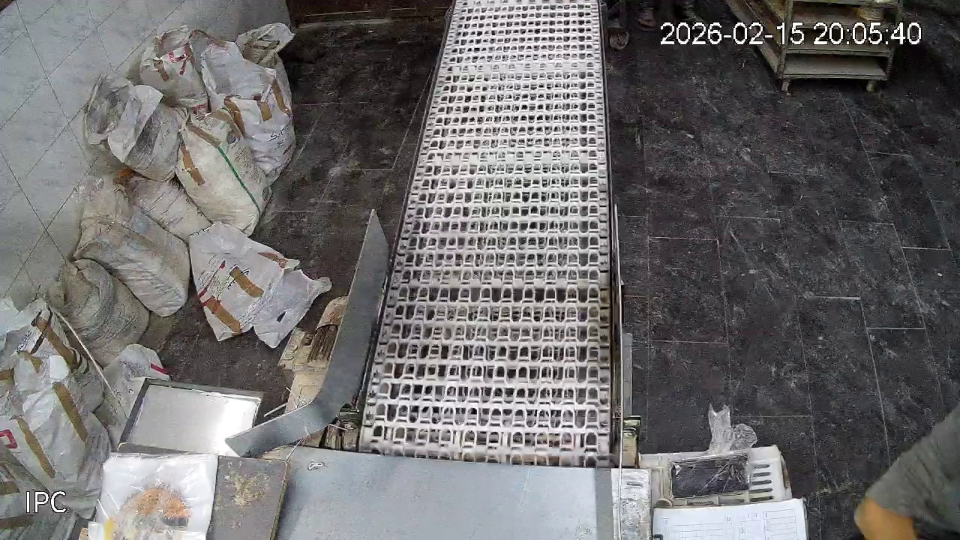

  (no detections — use 'draw' or 'add' to create one)
💾 Checkpoint saved (4369 frames)

╔═══════════════════════ COMMANDS ═════════════════════════╗
║                                                          ║
║  NAVIGATION                                              ║
║    n / next          → next frame                        ║
║    p / prev          → previous frame                    ║
║    g <N>             → go to frame N (1-based)           ║
║    np                → jump to next PENDING frame        ║
║                                                          ║
║  REVIEW                                                  ║
║    a                 → ✅ APPROVE  (add to dataset)       ║
║    r                 → ❌ REJECT   (exclude from dataset) ║
║    c                 → ✏️  CORRECTED (after your edits)    ║
║                                                          ║
║  EDIT DETECTIONS                                         ║
║    draw              → 🖱️  DRAW BOXES WITH MOUSE      

In [3]:
output_dir = "D:\\Recordings\\2026_02_05\\2026_02_16"
annotate(
    model_path=r"data/model/yolo_nano_detect_v12.pt",           # your YOLO .pt weights
    video_path=f"{output_dir}\\output_2026-02-15_19-59-34.mp4",
    workspace = f"{output_dir}\\annotation_workspace",
    yolo_output = f"{output_dir}\\yolo_dataset",
    stride=14,                                    # every 5th frame
    conf=0.8,                                   # min confidence
    device="",                                   # "" = auto, "cuda", "cpu"
    max_frames=None,                             # None = all frames
)

In [ ]:
from pathlib import Path

frames, cmap = load_checkpoint(Path(f"{output_dir}/annotation_workspace/checkpoint.json"))
export_yolo_dataset(frames, cmap, f"{output_dir}/yolo_dataset", val_ratio=0.2)